In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from load_blender import load_blender_data
from run_nerf_helpers import *
from run_nerf_adv import My_args
from run_nerf_adv import *
from PIL import Image
from numpy import asarray
from torchvision.utils import save_image
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

# default settings
torch.cuda.set_device(5)
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
print('device:', device)

args = My_args_llff()
args.device = device

device: cuda:5


In [2]:
K = None
images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                recenter=True, bd_factor=.75,
                                                                spherify=args.spherify)
hwf = poses[0,:3,-1]
poses = poses[:,:3,:4]
print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
if not isinstance(i_test, list):
    i_test = [i_test]

if args.llffhold > 0:
    print('Auto LLFF holdout,', args.llffhold)
    i_test = np.arange(images.shape[0])[::args.llffhold]

i_val = i_test
i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                (i not in i_test and i not in i_val)])

print('DEFINING BOUNDS')
if args.no_ndc:
    near = np.ndarray.min(bds) * .9
    far = np.ndarray.max(bds) * 1.
    
else:
    near = 0.
    far = 1.
print('NEAR FAR', near, far)

Loaded image data (378, 504, 3, 55) [378.         504.         416.23374465]
Loaded ./data/nerf_llff_data/trex 14.611281520672364 128.97241851887296
recentered (3, 5)
[[ 1.0000000e+00 -8.9834629e-10 -9.6571471e-09  6.5023249e-09]
 [ 8.9834634e-10  1.0000000e+00  7.2768644e-09 -6.6377899e-09]
 [ 9.6571471e-09 -7.2768644e-09  1.0000000e+00  4.0639531e-10]]
Data:
(55, 3, 5) (55, 378, 504, 3) (55, 2)
HOLDOUT view is 20
Loaded llff (55, 378, 504, 3) (120, 3, 5) [378.      504.      416.23373] ./data/nerf_llff_data/trex
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0


Reloading from ./logs/trex_test/100000.tar


/home/qhuang/miniconda3/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([378, 504, 3])
torch.Size([3, 378, 504])


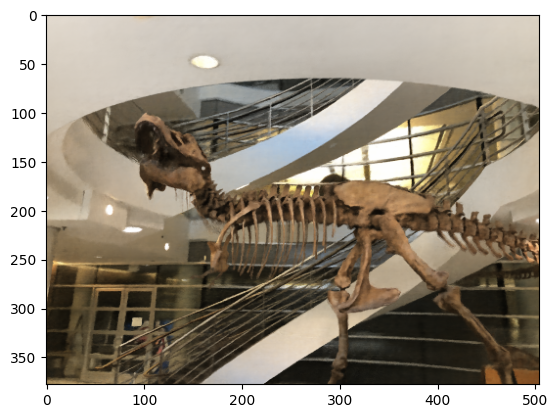

Found ckpts ['./logs/trex_test/100000.tar']
Reloading from ./logs/trex_test/100000.tar
rays_shape torch.Size([190512, 11])
torch.Size([378, 504, 3])


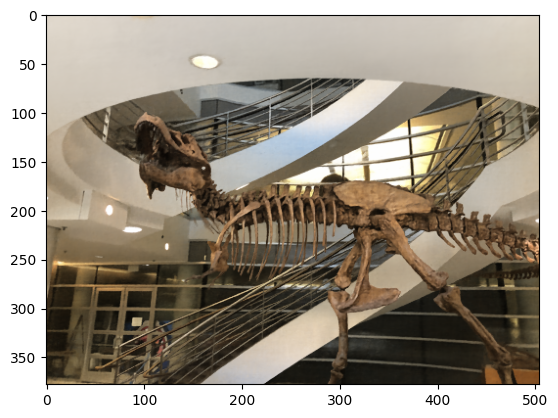

In [3]:
# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
# os.makedirs(os.path.join(basedir, expname), exist_ok=True)
# os.makedirs(os.path.join('experiment', expname), exist_ok=True)
# os.makedirs(os.path.join('experiment', expname, 'record'), exist_ok=True)
# Move testing data to GPU
poses = torch.Tensor(poses).to(device)

# show the target_pose and target_img
N_thresh = 6144
Loop = 2
target_pose_num = 5
target_pose, target_img = poses[target_pose_num], images[target_pose_num]
c2w=target_pose[:3,:4]
# target image
target_img = torch.Tensor(target_img).to(device)
net = get_pretrained_net(args)
# get all encoded points
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, encoded_points_all = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, ndc=True, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)

sh = torch.ones((H,W,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render_new(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, sh, args, chunk=1024*64)
print(my_adv_img.shape)
print(torch.permute(my_adv_img, (2, 0, 1)).shape)
plt.imshow(my_adv_img.to('cpu').numpy())
plt.show()


render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
with torch.no_grad():
    rgb, disp, acc, _ = render(H, W, K, chunk=args.chunk, c2w=c2w, **render_kwargs_test)
print(rgb.shape)
plt.imshow(rgb.to('cpu').numpy())